# COVID-19 Time Series Modelling

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## 1. Summary  
This report uses Ireland’s daily COVID-19 confirmed cases and deaths data (02 March 2020 to 24 January 2023) to build a lagged linear regression model linking cases to subsequent deaths, in order to address two counterfactual questions:  
	1.	Given the large number of deaths in the first stage of the pandemic, if extensive testing had been in place, how many cases would have been diagnosed?  
	2.	If vaccines had been ineffective against Omicron, how many deaths would have occurred?  

To reduce reporting noise and day-of-week (weekend) effects, both the cases and deaths time series are smoothed using a 7-day moving average (MA). A suitable time lag L is selected by scanning L=0 to 30 days and comparing performance metrics ($RMSE, MAE$, and $R^2$).  

Using the pre-vaccine period with more mature testing (Stage 2: 2020-09 to 2021-03), the optimal lag is found to be approximately L=16 days, and the fitted model is  

$$\text{death\_MA}(t)=\beta_0+\beta_1\cdot \text{case\_MA}(t-16)$$

This Stage 2 model is then used as a proxy for the “extensive testing / vaccine-ineffective severity” relationship. For Stage 1 (2020-03 to 2020-06), backcasting under the same deaths level estimates the diagnosed cases (in MA terms) to be approximately 112,919, compared with 23,048 observed, i.e., about 4.90× higher. For the Omicron period (Stage 3: 2021-12 to 2023-01), the counterfactual prediction under vaccine ineffectiveness gives an MA-sum of about 4,390 deaths, whereas the observed MA-sum is 678 deaths, i.e., about 6.48× higher (an increase of approximately 3,712).  

Overall, under the modelling assumptions, the results suggest that limited early testing may have led to substantial under-diagnosis, and that the “high cases, low deaths” pattern during Omicron is consistent with vaccines/immune protection reducing mortality risk. The modelling approach is intentionally simple (univariate linear regression with a single fixed lag) and does not explicitly account for changes in age structure, healthcare capacity, or treatment improvements; therefore, the counterfactual results should be interpreted as approximate, order-of-magnitude estimates rather than precise ground truth.  

Notes:  
- All “totals” reported in this report are computed as day-by-day sums of the 7-day moving-average series (MA-sum), consistent with the model inputs.
- The onset of Omicron dominance in Ireland is based on publicly available information (e.g., HPSC/WHO/official announcements). In this report, 2021-12-19 is used as the stage cut-point, consistent with the subsequent surge in cases.


## 2. Data Manipulation
### 2.1 Data import and cleaning
The COVID-19 dataset was loaded from a `.csv` file. The columns required for this analysis were then selected and copied into a separate working DataFrame to simplify subsequent processing and modelling.

In [2]:
file_path = "/Users/luke/Desktop/Sem2/EE6024/AS2/COVID-19_HPSC_Detailed_Statistics_Profile-01-23.csv"
df_origin = pd.read_csv(file_path)

#print("Shape:",df_origin.shape)
#print("Columns(first 30):",df_origin.columns.tolist()[:30])
#display(df_origin.head(5))

In [3]:
date = "Date"
case = "ConfirmedCovidCases"
death = "ConfirmedCovidDeaths"
dtd = "DeathsToday_DOD"

# Change the date in data to date time and sort-------
df = df_origin[[date,case,death,dtd]].copy()
df[date] = pd.to_datetime(df[date])
df = df.sort_values(date).reset_index(drop=True)

# Change the data type of case, death, std into value, non-value will show as NA--------
df[case]= pd.to_numeric(df[case], errors ="coerce")
df[death]= pd.to_numeric(df[death], errors="coerce")
df[dtd]=pd.to_numeric(df[dtd], errors="coerce")
# Remove NA data and reset the index to 0 ---------
df = df.dropna(subset=[case, death,dtd]).reset_index(drop=True)
#display(df.head(5))

### 2.2 Rolling: selecting the MA window

**Why choose a 7-day window?**  
COVID-19 data often exhibits strong weekend effects and reporting delays (e.g., backlogs being reported in batches), which makes the raw daily series highly volatile. A 7-day window covers a full week and smooths short-term noise without materially altering the longer-term trend. This improves model stability and makes the fitted parameters more interpretable.

- `rolling(window=7)`: the window length represents "use the most recent 7 days"
- `min_periods=7`: if fewer than 7 observations are available, return `NaN` to avoid unstable estimates at the beginning of a stage
- `.mean()`: computes the average within each rolling window

In [4]:
window = 7
min_periods = window
cases_ma = "Cases_MA"
deaths_ma = "Deaths_MA"
dtd_ma = "Deathtoday_MA"
#define rolling------
df[cases_ma] = df[case].rolling(window=window, min_periods=min_periods).mean()
df[deaths_ma] = df[death].rolling(window=window, min_periods=min_periods).mean()
df[dtd_ma] = df[dtd].rolling(window=window,min_periods=min_periods).mean()

df = df[[date,case,cases_ma,death,deaths_ma,dtd,dtd_ma]]
#display(df.head(10))

### 2.3 Parameter selection

In this report, **Deathtoday** (daily deaths counted by the **date of death occurrence**) is used as the main response variable \(y\), rather than **ConfirmedCovidDeaths** (a cumulative/confirmed deaths count). The reason is that the model aligns daily deaths with earlier daily cases through a lag \(L\). Using a “date of death” series better matches the causal time ordering and is therefore more appropriate for constructing and interpreting a lagged relationship.

By contrast, **ConfirmedCovidDeaths** is closer to a cumulative/confirmation-based measure and may include confirmation delays and backfilling effects. Using it directly in a daily lagged regression can introduce non-stationary trends and mix reporting definitions, which complicates interpretation. To keep the model inputs consistent, the **Deathtoday** series is also smoothed using a 7-day moving average.

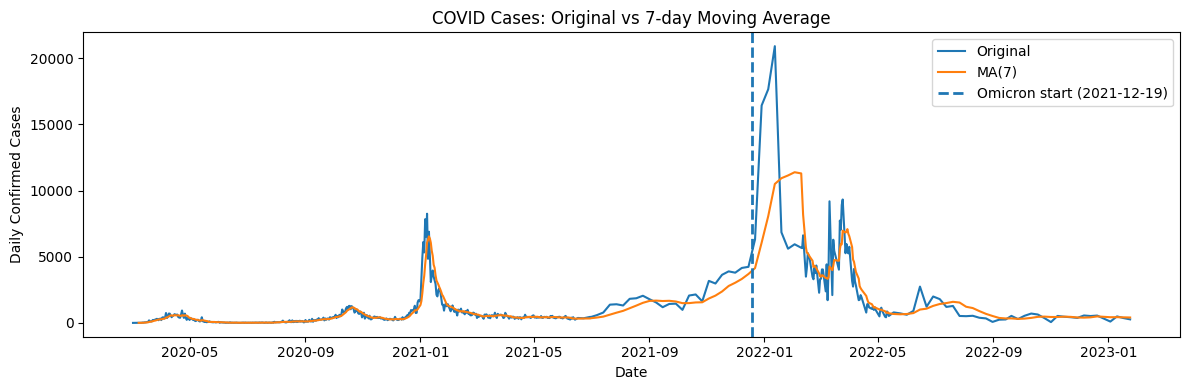

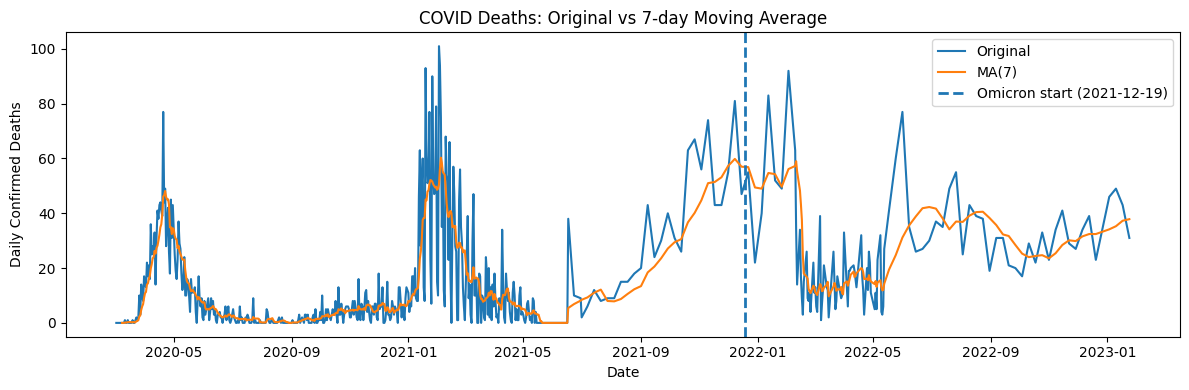

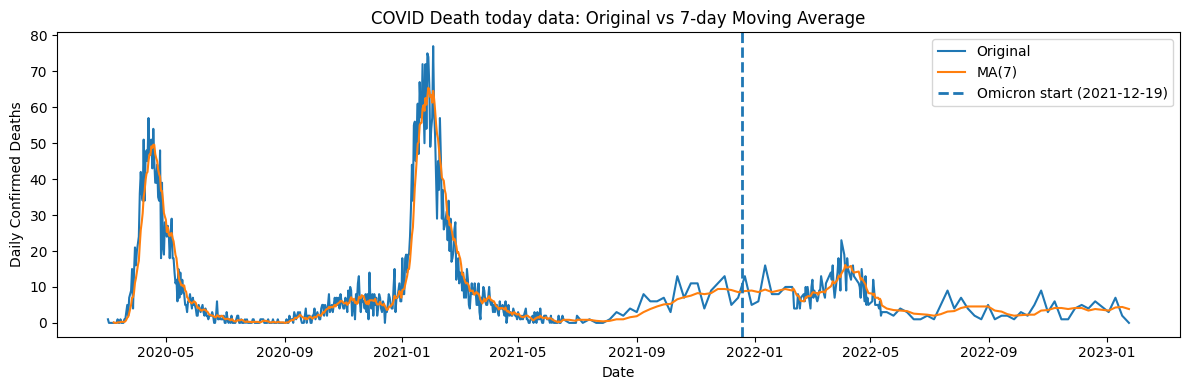

In [5]:
def plot_original_and_ma(df, x, y, y_ma, title, ylabel):
    omicron_start = pd.to_datetime("2021-12-19") # Consider 2021-12-19 as the start date of Omicron
    plt.figure(figsize=(12, 4))
    plt.plot(df[x], df[y], label="Original")
    plt.plot(df[x], df[y_ma], label=f"MA({window})")
    plt.title(title)
    plt.axvline(omicron_start, linestyle="--", linewidth=2, label="Omicron start (2021-12-19)")
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_original_and_ma(df, date, case, cases_ma,
                     title="COVID Cases: Original vs 7-day Moving Average",
                     ylabel="Daily Confirmed Cases")

plot_original_and_ma(df, date, death, deaths_ma,
                     title="COVID Deaths: Original vs 7-day Moving Average",
                     ylabel="Daily Confirmed Deaths")

plot_original_and_ma(df, date, dtd, dtd_ma,
                     title="COVID Death today data: Original vs 7-day Moving Average",
                     ylabel="Daily Confirmed Deaths")

### 2.4 Lag definition

Deaths typically lag behind diagnosed cases, since there is a time delay from infection/diagnosis to severe illness and death. Therefore, when building the model we use $\text{case\_MA}(t-L)$ to explain $\text{death\_MA}(t)$, where $L$ denotes the lag in days. In this report, the optimal $L$ is selected by scanning $L\in[0,30]$ and comparing performance metrics.

Model selection uses $RMSE$, $MAE$, and $R^2$:
- $MAE$: mean absolute error, a direct measure of the average daily (MA) prediction deviation;
- $RMSE$: root mean squared error, more sensitive to large errors near peaks and therefore useful for assessing peak fit;
- $R^2$: the proportion of variance explained, used to quantify how much of the deaths variability is captured by the model.

I choose the lag $L$ that minimises $RMSE$ as the primary lag, and use $R^2$ as an additional check on explanatory power (to reduce the risk that the selected lag arises from noise).

In [6]:
def fit_lag(df, L, x_col=cases_ma, y_col=dtd_ma):
    tmp = df[[date, x_col, y_col]].copy().sort_values(date)
    tmp["x_lag"] = tmp[x_col].shift(L)  # If deaths occur later than cases, use earlier cases to explain today's deaths
    tmp = tmp.dropna(subset=["x_lag", y_col])

    X = tmp[["x_lag"]].values  # Extract the x_lag values and assign them to X
    y = tmp[y_col].values      # Same for the response variable y

    model = LinearRegression()  # yhat = beta_0 + beta_1 * x
    model.fit(X, y)
    yhat = model.predict(X)     # Use the model to predict y from the same X, producing yhat

    rmse = np.sqrt(mean_squared_error(y, yhat))  # RMSE = sqrt( (1/n) * sum((y - yhat)^2) )
    mae  = mean_absolute_error(y, yhat)          # MAE  = (1/n) * sum(|y - yhat|)
    r2   = r2_score(y, yhat)                     # Coefficient of determination (R^2): closer to 1 is better
    return rmse, mae, r2, model.coef_[0], model.intercept_, len(tmp) #return rmse,mae,r2,beta1,beta0,n

In [7]:
def find_lag(df):
    rows = []
    # Trying to find the best lag in 0~31
    for L in range(0, 31):
        rmse, mae, r2, b1, b0, n = fit_lag(df, L)  # n is the number of valid samples used for fitting
        rows.append({"lag": L, "rmse": rmse, "mae": mae, "r2": r2, "beta1": b1, "beta0": b0, "n": n})
    
    res = pd.DataFrame(rows).sort_values("rmse").reset_index(drop=True)
    # sort_values: sort by rmse from small to large; reset_index: reset the row index so the first row starts at 0
    display(res.head(5))
    
    best_L = int(res.loc[0, "lag"])  # Take the lag value from the first row after sorting
    print(f"Best lag (by RMSE): {best_L} days")
    
    # Plot RMSE vs lag
    res_plot = res.sort_values("lag")  # Sort by lag from small to large
    plt.figure(figsize=(10,4))
    plt.plot(res_plot["lag"], res_plot["rmse"])
    plt.title("RMSE vs Lag (X=case_ma shifted by L, Y=death_today_ma)")
    plt.xlabel("Lag L (days)")
    plt.ylabel("RMSE")
    plt.tight_layout()
    plt.show()

## 3. Models
The model is a univariate linear regression (OLS). The model equation is: $$\widehat{\text{death\_today\_ma}}(t) = \beta_0 + \beta_1 \cdot \text{case\_ma}(t-L)$$  
where $\beta_0$ is the intercept, $\beta_1$ is the slope (interpretable as “how many MA deaths increase for each additional 1 MA case”), and $L$ is the lag in days.   

Model selection and iterative strategy (from global to stage-based):  
The global fit scatter plot and the “actual vs predicted” time-series comparison indicate that a single model struggles to explain the deaths–cases relationship across different phases (early pandemic, vaccination period, and Omicron). This is reflected by large peak mismatches, structured residual patterns, and unstable optimal lags across stages. These observations suggest that the relationship is non-stationary over time, as mortality risk changes due to factors such as testing strategy, healthcare conditions, vaccination, and variants.  

Therefore, to improve interpretability and to address the counterfactual questions (Q1/Q2), a stage-based modelling approach is adopted: Stage2 (the pre-vaccination winter wave) is used to build a “vaccine-ineffective / high-severity” baseline model, which is then applied for backcasting cases in Q1 and for counterfactual death prediction during the Omicron period in Q2.  

In [8]:
def pred(df,best_L):
    # Create a new table and add the lagged case_ma column
    tmp = df[[date, cases_ma, dtd_ma]].copy()
    tmp["case_lag"] = tmp[cases_ma].shift(best_L)
    tmp = tmp.dropna(subset=["case_lag", dtd_ma]).reset_index(drop=True)
    # Drop rows containing NaN values: the first few days are NaN due to the moving average,
    # and additional days become NaN because shifting by the lag leaves empty entries.
    # In other words, from this point onward, case_lag corresponds to cases best_L days earlier than the deaths.
    
    # Assign features and target
    X = tmp[["case_lag"]].values
    y = tmp[dtd_ma].values
    
    final_model = LinearRegression()
    final_model.fit(X, y)
    tmp["death_pred"] = final_model.predict(X) #yhat=death_predict
    
    print("Model:")
    print("  death_today_ma ≈ beta0 + beta1 * case_ma(t - L)")
    print(f"  L = {best_L}")
    print(f"  beta0 = {final_model.intercept_:.4f}")
    print(f"  beta1 = {final_model.coef_[0]:.6f}")
    
    # Compute RMSE and MAE to evaluate prediction accuracy
    rmse = np.sqrt(mean_squared_error(y, tmp["death_pred"]))
    mae  = mean_absolute_error(y, tmp["death_pred"])
    r2   = r2_score(y, tmp["death_pred"])
    print(f"  RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")
    
    # Plot actual vs predicted deaths over time
    plt.figure(figsize=(12,4))
    plt.plot(tmp[date], tmp[dtd_ma], label="Actual (death_today_ma)")
    plt.plot(tmp[date], tmp["death_pred"], label="Predicted(death)")
    plt.title(f"Deaths: Actual vs Predicted (lag L={best_L})")
    plt.xlabel("Date")
    plt.ylabel("7-day MA deaths")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Scatter plot: shows the paired points after time alignment (e.g., cases on Mar 8 aligned with deaths on Mar 21)
    plt.figure(figsize=(5,5))
    plt.scatter(tmp["case_lag"], tmp[dtd_ma], s=10)
    plt.title(f"Scatter: death_today_ma vs case_ma(t-{best_L})")
    plt.xlabel(f"case_ma lagged by {best_L} days")
    plt.ylabel("death_today_ma")
    plt.tight_layout()
    plt.show()

### 3.1 Stage-based modelling
To better address Q1 and Q2, the dataset is divided into different time periods:    
- Stage 1: 02 March 2020 – June 2020  
- Stage 2: September 2020 – March 2021, used as the high-mortality baseline under the “vaccine-ineffective” assumption; this stage is used for backcasting in Q1 and for predicting deaths using Omicron-period cases in Q2  
- Stage 3: December 2021 to the end of the dataset, used to provide additional analysis specific to the Omicron period  

In [9]:
# Divide df into different stages
df["Date"] = pd.to_datetime(df["Date"]).dt.tz_localize(None)

stage1_end = pd.to_datetime("2020-06-30")
stage2_start = pd.to_datetime("2020-09-01")
stage2_end = pd.to_datetime("2021-03-31")
stage3_start = pd.to_datetime("2021-12-19")

stage1 = df[df["Date"]<=stage1_end].copy()
stage2 = df[(df["Date"]>=stage2_start) & (df["Date"]<=stage2_end)].copy()
stage3 = df[df["Date"]>= stage3_start].copy()
stage1 = stage1.dropna(subset=["Cases_MA", "Deathtoday_MA"]).sort_values("Date").reset_index(drop=True)
stage2 = stage2.dropna(subset=["Cases_MA", "Deathtoday_MA"]).sort_values("Date").reset_index(drop=True)
stage3 = stage3.dropna(subset=["Cases_MA", "Deathtoday_MA"]).sort_values("Date").reset_index(drop=True)

,lag,rmse,mae,r2,beta1,beta0,n
0,16,8.640926,6.237233,0.776910,0.012718,2.877096,196
1,15,8.648152,6.218365,0.776053,0.012725,2.830612,197
2,17,8.734259,6.301850,0.772596,0.012670,2.963364,195
3,14,8.781962,6.246254,0.768579,0.012678,2.839386,198
4,18,8.960392,6.386936,0.761195,0.012563,3.110379,194


Best lag (by RMSE): 16 days


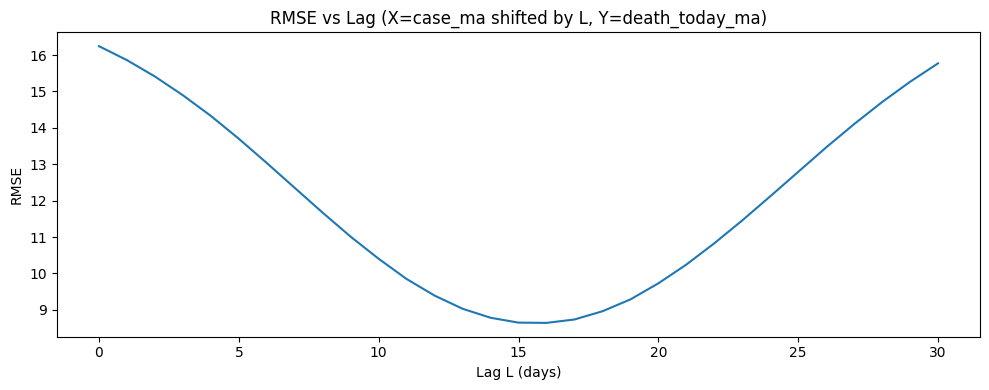

In [10]:
find_lag(stage2)

Model:
  death_today_ma ≈ beta0 + beta1 * case_ma(t - L)
  L = 16
  beta0 = 2.8771
  beta1 = 0.012718
  RMSE=8.641, MAE=6.237, R2=0.777


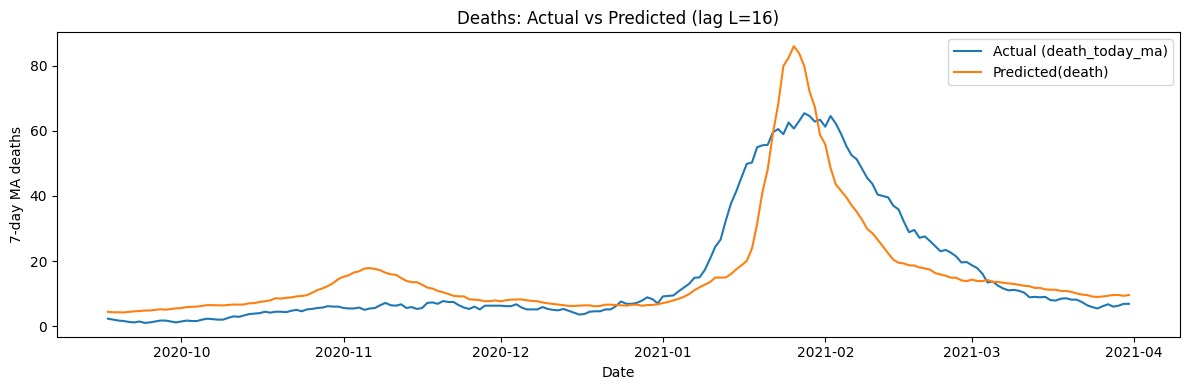

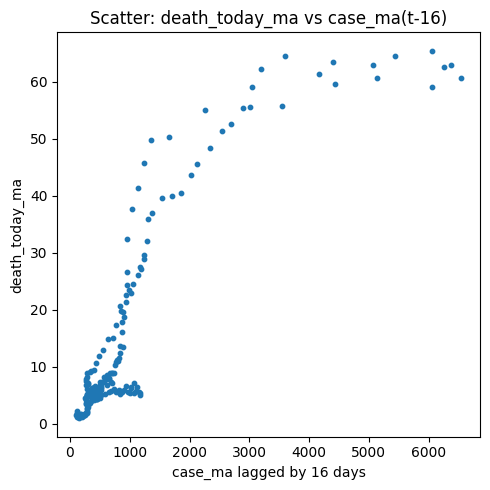

In [11]:
pred(stage2,16)

The model captures the overall dynamics of the winter wave well ($R^2$ is approximately 0.78), but it often overestimates the height/shape of the peak. This suggests that the relationship between deaths and cases is not strictly linear and may vary over time.  

The linear lag model reproduces the timing of the main peak, but it overestimates the sharpness of the peak. This indicates that deaths respond to cases through a distributed delay (rather than a single fixed lag) and potentially nonlinear effects.

## 4. Analysis of performance and discussion
In practice, I first attempted modelling using the full (global) dataset and then Stage 1 separately, aiming to identify the best approach to answer Q1. However, the results indicate that:  

For the global model, the performance metrics ($RMSE$, $MAE$, and $R^2$) are poor. In the comparison plots, the gap between observed and predicted deaths is large, and the scatter plot shows clear clustering across different phases: at similar case levels, the death levels differ substantially between stages. This implies that a single linear relationship over the entire time period is not valid, and therefore stage-based modelling is required.

,lag,rmse,mae,r2,beta1,beta0,n
0,13,13.359470,9.028013,0.104363,0.002570,7.354617,587
1,14,13.362633,9.042171,0.104806,0.002574,7.362547,586
2,12,13.363169,9.016036,0.103061,0.002554,7.357289,588
3,11,13.372213,9.005935,0.101059,0.002530,7.369397,589
4,15,13.372724,9.058314,0.104400,0.002569,7.380283,585


Best lag (by RMSE): 13 days


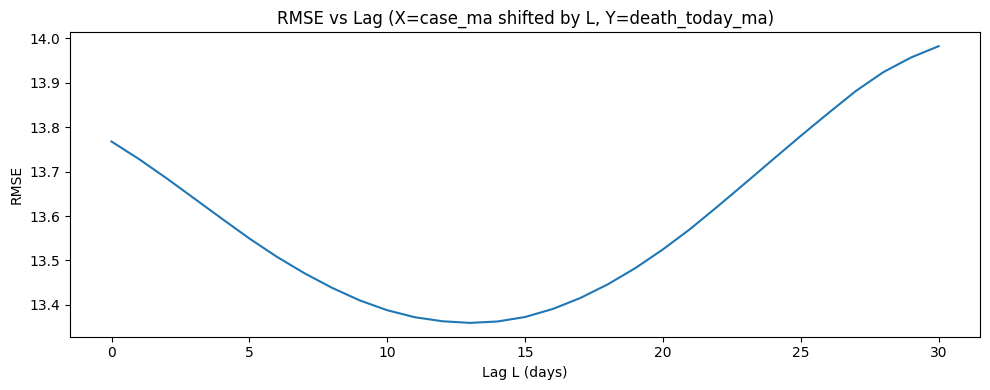

In [12]:
find_lag(df) #find a best lag value for global df

Model:
  death_today_ma ≈ beta0 + beta1 * case_ma(t - L)
  L = 13
  beta0 = 7.3546
  beta1 = 0.002570
  RMSE=13.359, MAE=9.028, R2=0.104


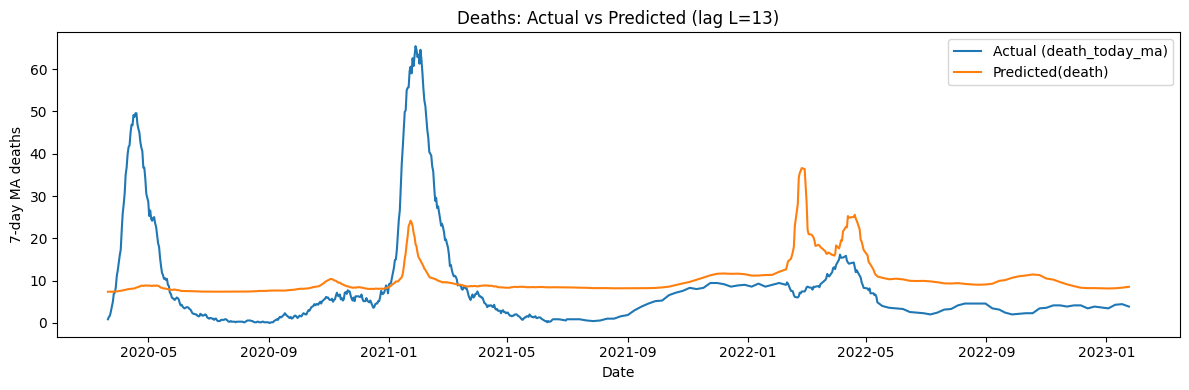

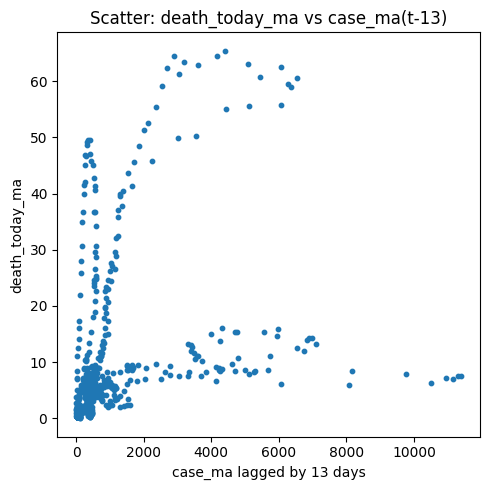

In [13]:
pred(df,13) #build a model based on global df

The global model has $R^2 \approx 0.10$, indicating insufficient explanatory power, so a stage-based approach is adopted. Stage 2 achieves a much better fit with $R^2 \approx 0.78$, and is therefore used as the primary model for counterfactual inference.

,lag,rmse,mae,r2,beta1,beta0,n
0,1,3.683828,2.867059,0.944867,0.076198,-0.532122,114
1,2,3.765710,2.849689,0.942429,0.076099,-0.508255,113
2,0,3.895899,2.963453,0.938278,0.075926,-0.479646,115
3,3,4.137779,2.937633,0.930528,0.075627,-0.408330,112
4,4,4.643227,3.054026,0.912554,0.074902,-0.253446,111


Best lag (by RMSE): 1 days


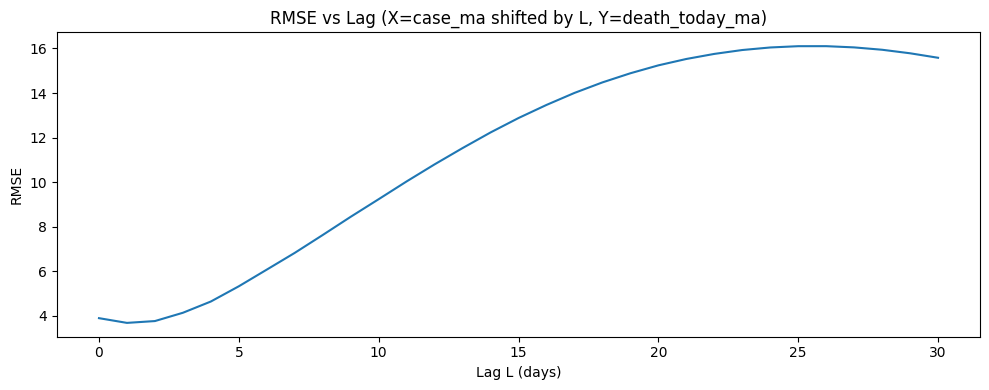

In [14]:
find_lag(stage1) #find a best lag value for stage1

For Stage 1, although the within-stage fit can yield a high $R^2$, this is largely driven by a shared trend (cases and deaths rise and fall together). As a result, the estimated Stage 1 lag is unstable, and using Stage 1 for backcasting creates a closed loop that fails to reflect the counterfactual difference implied by “extensive testing.” Therefore, Stage 1 is not used as the baseline mapping for Q1.

Based on the results above, Stage 2 is the most suitable time period to use for answering Q1.

## 5. Conclusion
### 5.1 Q1: Given the large number of deaths in the first stage of the pandemic, if extensive testing was in place how many cases would have been diagnosed?  

During modelling, the univariate linear regression used is: $$\widehat{death\_ma}(t) = \beta_0 + \beta_1 \cdot case\_ma(t-L)$$ 
However, backcasting is equivalent to: given $death\_ma(t)$, solve for $case\_ma(t-L)$.  
Thus: $$\widehat{case\_ma}(t-L) = \frac{death\_ma(t) - \beta_0}{\beta_1}$$
The resulting $\widehat{case\_ma}(t-L)$ (aligned by $+L$ days in time) represents the diagnosed case level in the 7-day moving-average sense, and can be used as an approximate indicator of the case magnitude “if extensive testing had been in place.”

In [15]:
def backcast(stage, L, beta0, beta1,
    date_col="Date", cases_ma_col="Cases_MA", deaths_ma_col="Deathtoday_MA"):
    s = stage[[date_col, cases_ma_col, deaths_ma_col]].copy().sort_values(date_col).reset_index(drop=True)

    # Backcast: case_ma(t-L) = (death_ma(t) - beta0) / beta1
    s["cases_est_lagged"] = (s[deaths_ma_col] - beta0) / beta1

    # Plausibility constraint: cases cannot be negative
    s["cases_est_lagged"] = s["cases_est_lagged"].clip(lower=0)

    # Assign the backcast cases to the corresponding date t-L
    s["Date_lagged"] = s[date_col] - pd.to_timedelta(L, unit="D")

    # Align with the true cases_ma from the global df
    actual = df[[date_col, cases_ma_col]].copy()
    actual = actual.rename(columns={date_col: "Date_lagged", cases_ma_col: "cases_actual"})

    out = s.merge(actual, on="Date_lagged", how="left")
    out = out.rename(columns={"cases_est_lagged": "cases_est"})

    # Difference / ratio (avoid division by zero for the ratio)
    out["delta_cases"] = out["cases_est"] - out["cases_actual"]
    out["ratio_cases"] = out["cases_est"] / out["cases_actual"].replace(0, np.nan)

    return out

In [16]:
def summarize_backcast(res):
    return {
        "sum_actual": float(res["cases_actual"].sum(skipna=True)),
        "sum_est": float(res["cases_est"].sum(skipna=True)),
        "multiplier": float(res["cases_est"].sum(skipna=True) / res["cases_actual"].sum(skipna=True))
    }

In [17]:
res_stage1=backcast(stage1, L=16, beta0=2.8771, beta1=0.012718)# Results using Stage 1 data with the Stage 2 model coefficients (beta0, beta1)

In [18]:
res_stage1 = res_stage1.dropna(subset=["cases_actual"]).copy()
summarize_backcast(res_stage1)

{'sum_actual': 23048.14285714286,
 'sum_est': 112918.52155550063,
 'multiplier': 4.899245993718145}

This result indicates that, under the Stage 2 deaths–cases relationship, if Stage 1 (2020-03 to 2020-06) had extensive testing in place, the implied diagnosed case scale (7-day MA-sum) would be approximately 112,919 (compared with an observed 7-day MA-sum of about 23,048), i.e., about 4.899× higher.

### 5.2 Q2: If the vaccines had been ineffective against ”Omicron”, how many deaths would have occured?
Here, the Stage 2 model is also used: the Omicron-period case counts are substituted into the model to estimate the counterfactual number of deaths under the assumption that vaccines were ineffective.

In [19]:
L = 16
b0 = 2.8771
b1 = 0.012718

tmp = stage3[["Date", "Cases_MA", "Deathtoday_MA"]].copy().sort_values("Date").reset_index(drop=True)

tmp["case_lag"] = tmp["Cases_MA"].shift(L)
tmp = tmp.dropna(subset=["case_lag"]).copy()

tmp["death_pred"] = b0 + b1 * tmp["case_lag"]   # counterfactual deaths if vaccines ineffective


sum_pred = tmp["death_pred"].sum()
sum_obs = tmp["Deathtoday_MA"].sum()

print("Observed deaths (MA sum):", sum_obs)
print("Counterfactual deaths if vaccines ineffective (MA sum):", sum_pred)
print("Extra deaths:", sum_pred - sum_obs)
print("Multiplier:", sum_pred / sum_obs)

Observed deaths (MA sum): 678.0
Counterfactual deaths if vaccines ineffective (MA sum): 4390.250486285714
Extra deaths: 3712.250486285714
Multiplier: 6.475295702486304


Using the Stage 2 model and substituting the Omicron-period case counts, the counterfactual prediction under vaccine ineffectiveness gives 4,390 deaths, which is approximately 6.47× the observed number of deaths.

## 6. References
Data source:   
- Health Protection Surveillance Centre (HPSC), Ireland. COVID-19 Detailed Statistics Profile (Excel dataset)


Code examples /  EE6024 module teaching materials (provided via Canvas):
- Covid-assignment-jupyter-25
- Python_Tutorial

Python libraries
- McKinney, W. (2010). Data structures for statistical computing in Python. Proceedings of the 9th Python in Science Conference (SciPy). (pandas)
- Harris, C. R., et al. (2020). Array programming with NumPy. Nature, 585, 357–362. (NumPy)
- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90–95. (Matplotlib)
- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825–2830. (scikit-learn)

This report uses pandas for data handling, numpy for numerical operations, matplotlib for plotting, and scikit-learn for linear regression and performance metrics (RMSE/MAE/$R^2$).
